In [ ]:
import slicetca
import torch
import numpy as np
import pandas as pd
import pickle
import scipy.ndimage as spnd
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib
import gdown

from functions import *

dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT'
subjects = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
picks=['MEG 130', 'MEG 139','MEG 133','MEG 117','MEG 140','MEG 127','MEG 128','MEG 109','MEG 135','MEG 132','MEG 137',
 'MEG 131','MEG 129','MEG 118','MEG 134','MEG 136','MEG 141','MEG 116','MEG 114','MEG 115']

picks = None

data_dict = data_load(dir, subjects, picks, avoid_reading=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_18_2_ti_166-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_18_3_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_18_3_e_114-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1 matching events found
No baseline correction a

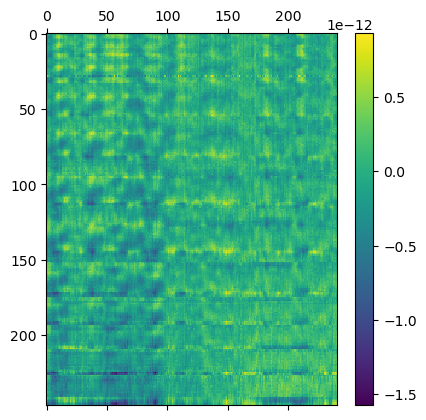

In [2]:
plt.matshow(np.squeeze(data_dict['BCOM_18_4']['le_124']), aspect='auto', cmap='viridis')
plt.colorbar()  

In [3]:
trial_1, trial_2, trial_3 = {}, {}, {}
trial_1['BCOM_18_2'] = data_dict['BCOM_18_2']
trial_2['BCOM_18_3'] = data_dict['BCOM_18_3']
trial_3['BCOM_18_4'] = data_dict['BCOM_18_4']

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

trial_1_tensor, t1_idxs = data_to_tensor(trial_1)
trial_2_tensor, t2_idxs = data_to_tensor(trial_2)
trial_3_tensor, t3_idxs = data_to_tensor(trial_3)
trial_1_tensor = trial_1_tensor / trial_1_tensor.std()
trial_2_tensor = trial_2_tensor / trial_2_tensor.std()
trial_3_tensor = trial_3_tensor / trial_3_tensor.std()

In [9]:
trial_3_tensor.shape

torch.Size([11, 247, 241])

In [4]:
components_1, model_1 = slicetca.decompose(trial_1_tensor,
                                       number_components=(2,2,1),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

components_2, model_2 = slicetca.decompose(trial_2_tensor,
                                       number_components=(2,2,1),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

components_3, model_3 = slicetca.decompose(trial_3_tensor,
                                        number_components=(2,2,1),
                                        positive=False,
                                        learning_rate=5*10**-3,
                                        min_std=10**-5,
                                        max_iter=10000,
                                        seed=0)

The model converged. Loss: 0.000148359511513263 :   8%|▊         | 815/10000 [00:05<01:01, 148.46it/s]
The model converged. Loss: 5.1256243750685826e-05 :  10%|█         | 1032/10000 [00:05<00:47, 189.05it/s]
The model converged. Loss: 0.22289827466011047 :  51%|█████▏    | 5141/10000 [00:27<00:25, 189.50it/s]


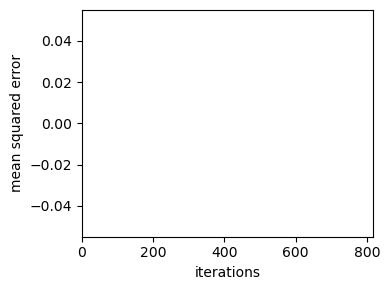

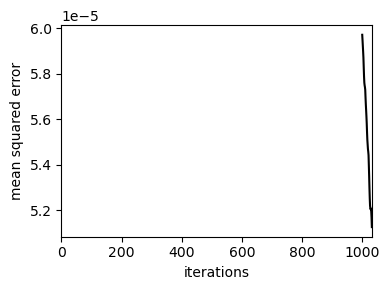

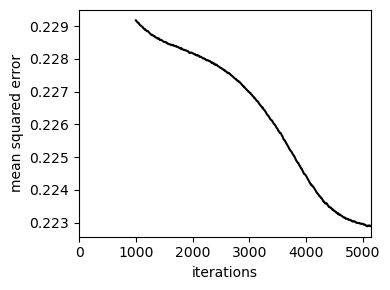

In [5]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model_1.losses)), model_1.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model_1.losses))
plt.tight_layout()

plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model_2.losses)), model_2.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model_2.losses))
plt.tight_layout()

plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model_3.losses)), model_3.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model_3.losses))
plt.tight_layout()

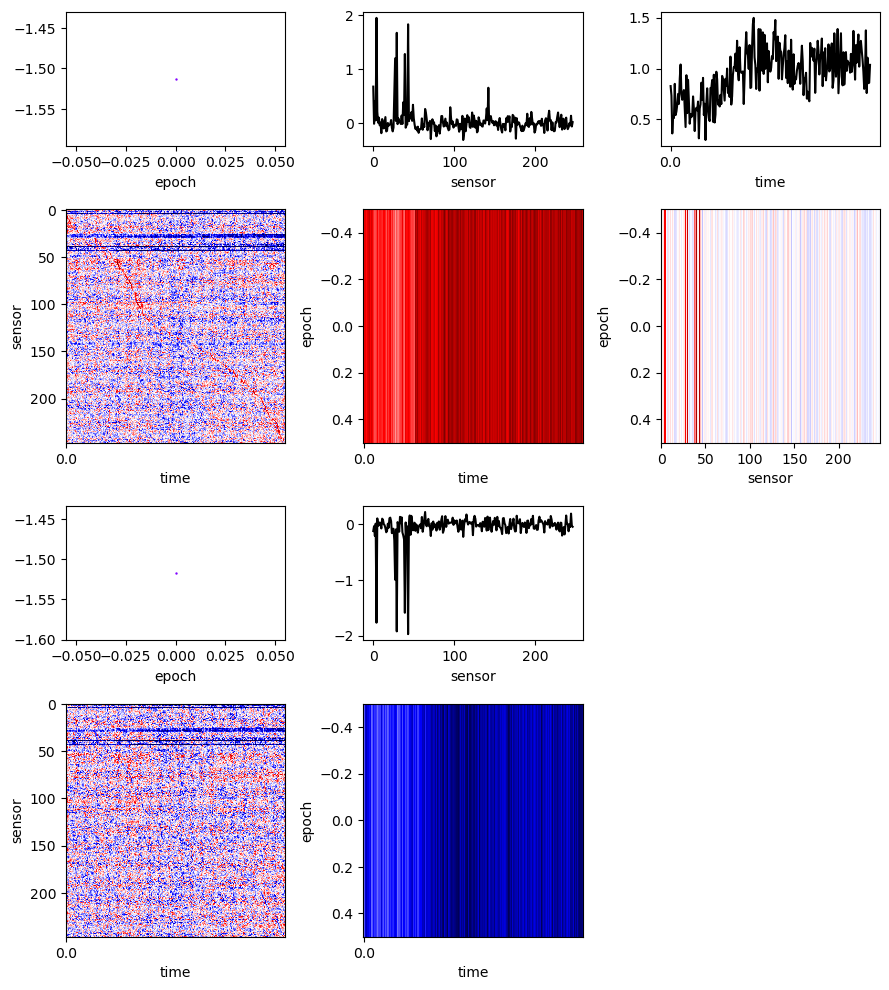

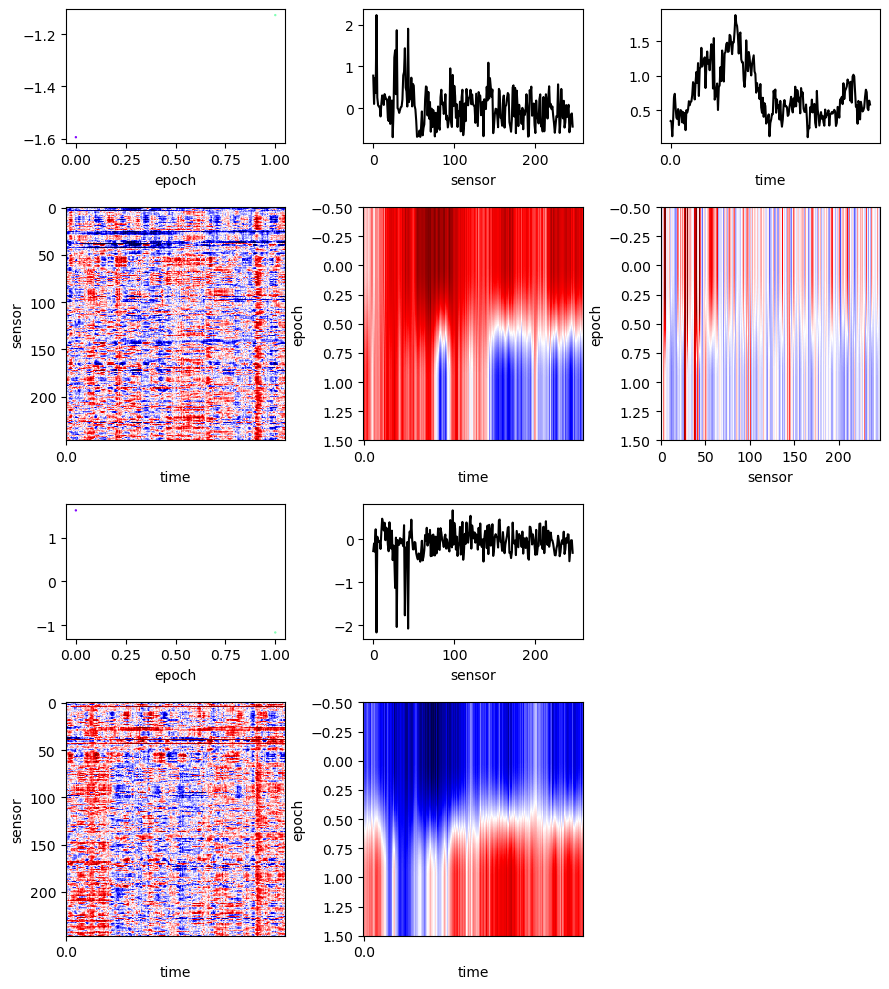

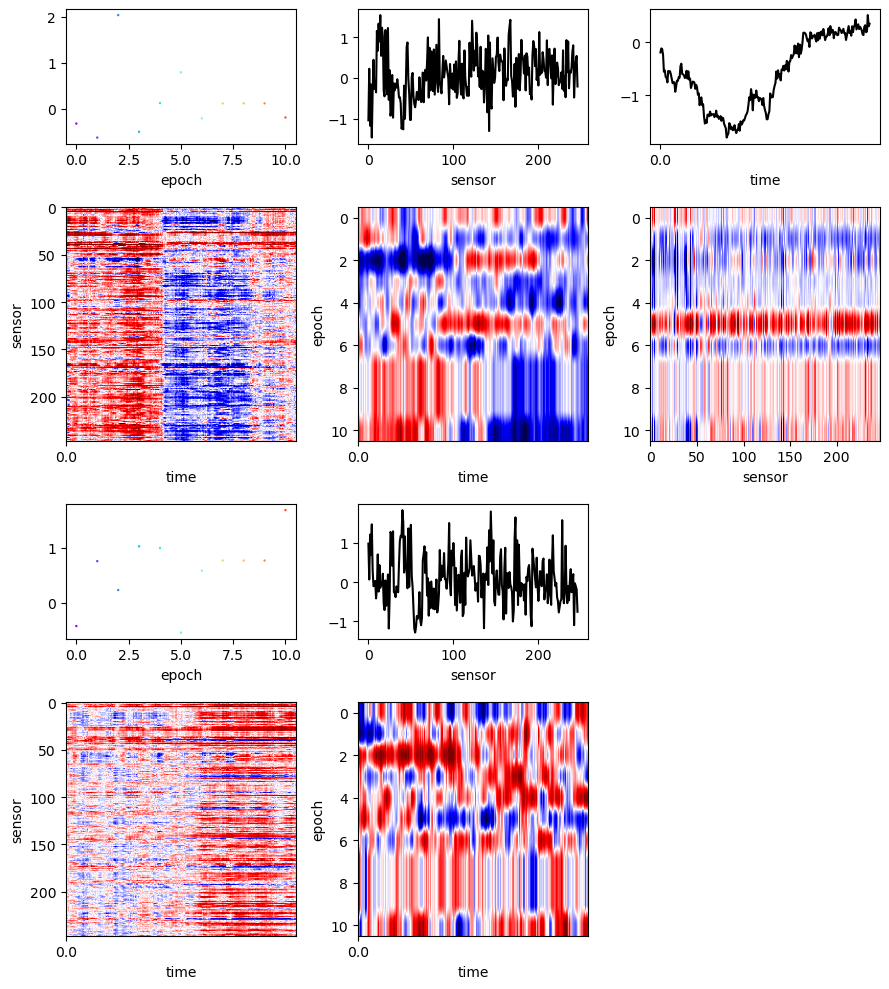

In [19]:
# we sort the neurons of the trial slices according to their peak activity in the first slice.
cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t1_idxs)) for i in range(len(t1_idxs))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_1[0][1][0], axis=1))

axes = slicetca.plot(model_1,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t1_idxs), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s18_t1_overt_all.png')

cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t2_idxs)) for i in range(len(t2_idxs))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_1[0][1][0], axis=1))

axes = slicetca.plot(model_2,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t2_idxs), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s18_t2_overt_all.png')

cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t3_idxs)) for i in range(len(t3_idxs))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_1[0][1][0], axis=1))

axes = slicetca.plot(model_3,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t3_idxs), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s18_t3_overt_all.png')


In [11]:
subject_19 = ['BCOM_19_2', 'BCOM_19_3', 'BCOM_19_4']
picks = None

data_dict_s19 = data_load(dir, subject_19, picks, avoid_reading=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_19_2_ti_166-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_19_2_te_164-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/OVERT/BCOM_19_2_li_126-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1 matching events found
No baseline correction

In [14]:
trial_1_s19, trial_2_s19, trial_3_s19 = {}, {}, {}
trial_1_s19['BCOM_19_2'] = data_dict_s19['BCOM_19_2']
trial_2_s19['BCOM_19_3'] = data_dict_s19['BCOM_19_3']
trial_3_s19['BCOM_19_4'] = data_dict_s19['BCOM_19_4']

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

trial_1_tensor_s19, t1_idxs_s19 = data_to_tensor(trial_1_s19)
trial_2_tensor_s19, t2_idxs_s19 = data_to_tensor(trial_2_s19)
trial_3_tensor_s19, t3_idxs_s19 = data_to_tensor(trial_3_s19)
trial_1_tensor_s19 = trial_1_tensor_s19 / trial_1_tensor_s19.std()
trial_2_tensor_s19 = trial_2_tensor_s19 / trial_2_tensor_s19.std()
trial_3_tensor_s19 = trial_3_tensor_s19 / trial_3_tensor_s19.std()

components_1_s19, model_1_s19 = slicetca.decompose(trial_1_tensor_s19,
                                       number_components=(2,2,1),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

components_2_s19, model_2_s19 = slicetca.decompose(trial_2_tensor_s19,
                                       number_components=(2,2,1),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

components_3_s19, model_3_s19 = slicetca.decompose(trial_3_tensor_s19,
                                        number_components=(2,2,1),
                                        positive=False,
                                        learning_rate=5*10**-3,
                                        min_std=10**-5,
                                        max_iter=10000,
                                        seed=0)

The model converged. Loss: 0.2573000490665436 :  28%|██▊       | 2763/10000 [00:15<00:40, 180.27it/s]


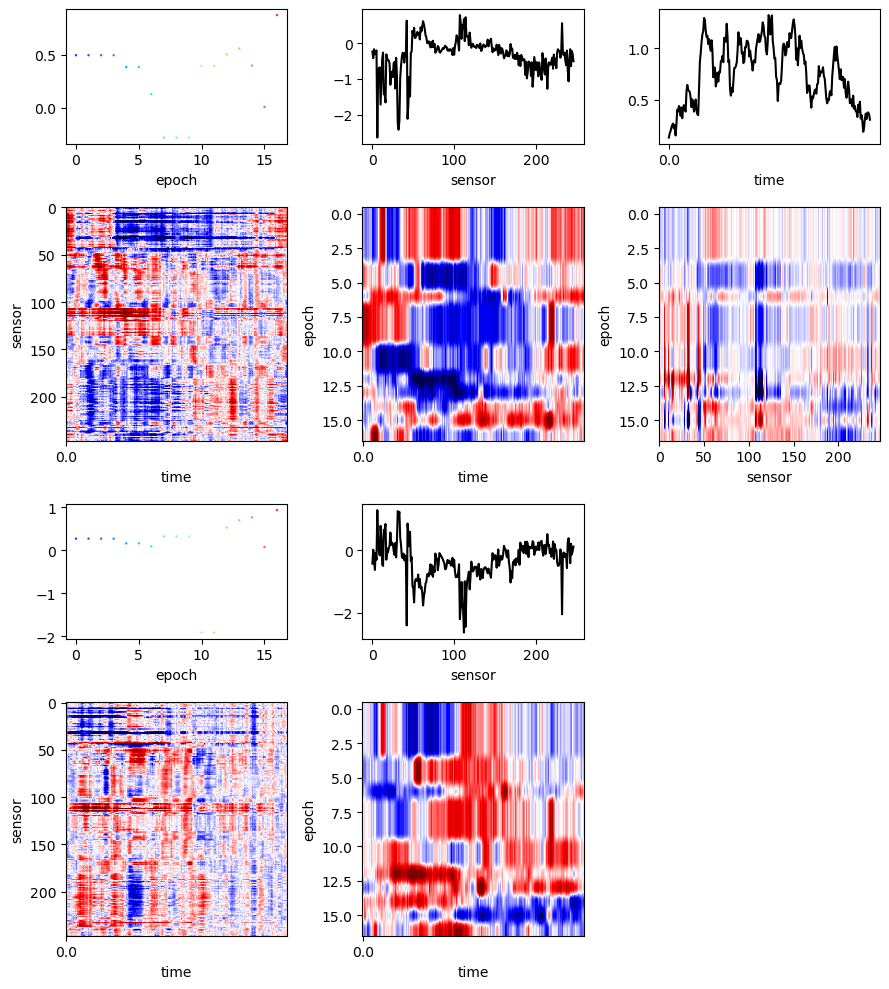

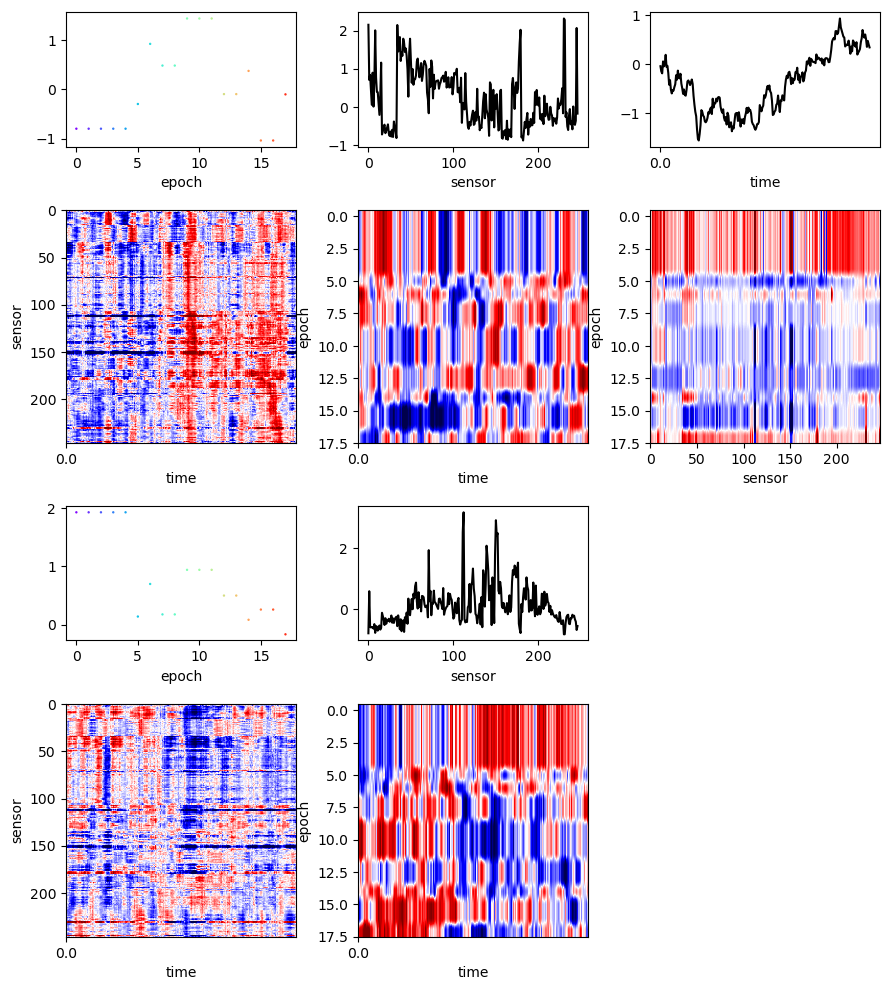

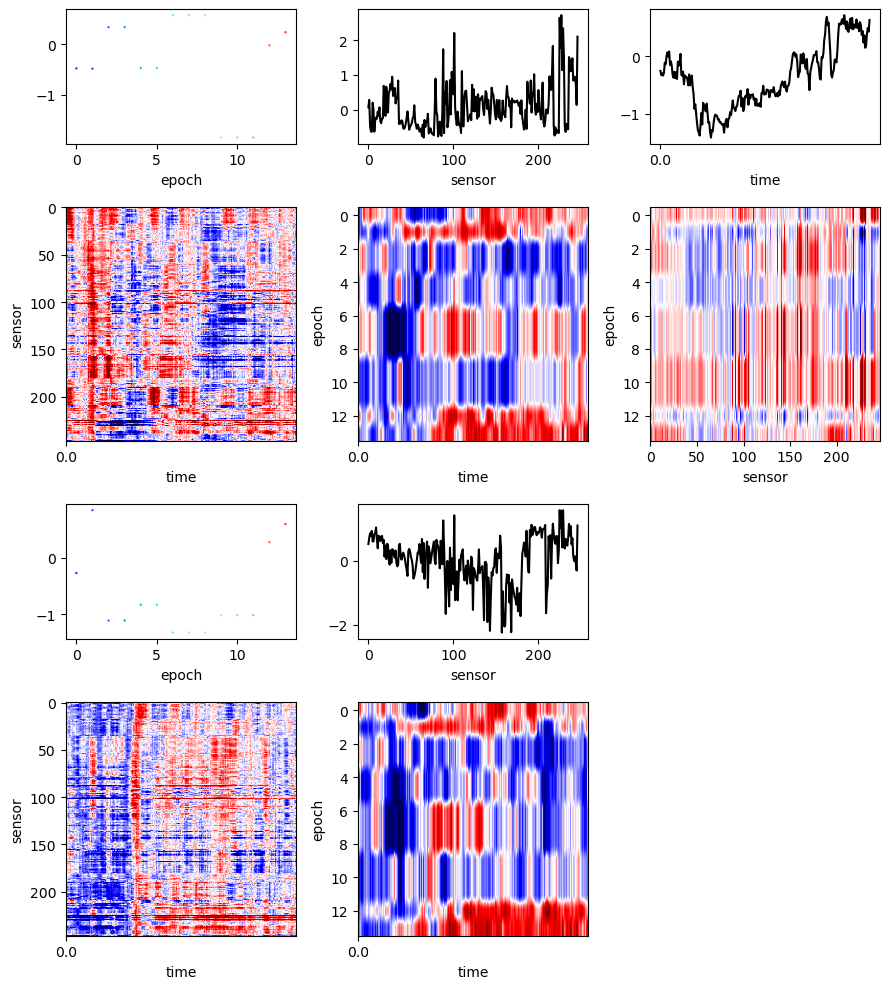

In [20]:
# we sort the neurons of the trial slices according to their peak activity in the first slice.
cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t1_idxs_s19)) for i in range(len(t1_idxs_s19))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_1_s19[0][1][0], axis=1))

axes = slicetca.plot(model_1_s19,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t1_idxs_s19), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s19_t1_overt_all.png')

cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t2_idxs_s19)) for i in range(len(t2_idxs_s19))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_2_s19[0][1][0], axis=1))

axes = slicetca.plot(model_2_s19,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t2_idxs_s19), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s19_t2_overt_all.png')

cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(t3_idxs_s19)) for i in range(len(t3_idxs_s19))])

sensor_sorting_peak_time = np.argsort(np.argmax(components_3_s19[0][1][0], axis=1))

axes = slicetca.plot(model_3_s19,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 241, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 241, 1)),
              sorting_indices=(np.array(t3_idxs_s19), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('s189_t3_overt_all.png')
